# ==== Import Library ====

In [1]:
# import library
import argparse,copy,h5py, os,sys,time,socket
import numpy as np
import tensorflow as tf
import torch,torchvision,torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from   torchsummary import summary
from   torch.autograd.variable import Variable

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import ticker,colors

# seed value and plotly
init_notebook_mode(connected=True); torch.manual_seed(7); torch.cuda.manual_seed_all(7); np.set_printoptions(suppress=True,precision=3,); tf.set_random_seed(7)

# ==== Set up the Network ====

In [2]:
# need the module 
class AllConvNet(nn.Module):
    
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1,bias=False)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,bias=False)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2,bias=False)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1,bias=False)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2,bias=False)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.conv8 = nn.Conv2d(192, 192, 1,bias=False)
        self.class_conv = nn.Conv2d(192, n_classes, 1,bias=False)

    def forward(self, x):
        
        conv1_out = F.relu(self.conv1(x))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        
        conv4_out = F.relu(self.conv4(conv3_out))
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        
        conv7_out = F.relu(self.conv7(conv6_out))
        conv8_out = F.relu(self.conv8(conv7_out))
        class_out = F.relu(self.class_conv(conv8_out))
        pool_out  = F.adaptive_avg_pool2d(class_out, 1)
        
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out
class AllConvNet_BN(nn.Module):
    
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_size,96, 3, padding=1,bias=False)
        self.bn1   = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,bias=False)
        self.bn2   = nn.BatchNorm2d(96)

        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2,bias=False)
        self.bn3   = nn.BatchNorm2d(96)
        
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1,bias=False)
        self.bn4   = nn.BatchNorm2d(192)

        self.conv5 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn5   = nn.BatchNorm2d(192)

        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2,bias=False)
        self.bn6   = nn.BatchNorm2d(192)
        
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn7   = nn.BatchNorm2d(192)
        
        self.conv8 = nn.Conv2d(192, 192, 1,bias=False)
        self.bn8   = nn.BatchNorm2d(192)
        
        self.class_conv = nn.Conv2d(192, n_classes, 1,bias=False)
    def forward(self, x):
        
        conv1_out = F.relu(self.conv1(x))
        conv1_out = self.bn1(conv1_out)
        
        conv2_out = F.relu(self.conv2(conv1_out))
        conv2_out = self.bn2(conv2_out)

        conv3_out = F.relu(self.conv3(conv2_out))
        conv3_out = self.bn3(conv3_out)
        
        conv4_out = F.relu(self.conv4(conv3_out))
        conv4_out = self.bn4(conv4_out)

        conv5_out = F.relu(self.conv5(conv4_out))
        conv5_out = self.bn5(conv5_out)

        conv6_out = F.relu(self.conv6(conv5_out))
        conv6_out = self.bn6(conv6_out)
        
        conv7_out = F.relu(self.conv7(conv6_out))
        conv7_out = self.bn7(conv7_out)

        conv8_out = F.relu(self.conv8(conv7_out))
        conv8_out = self.bn8(conv8_out)

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out  = F.adaptive_avg_pool2d(class_out, 1)
        
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out
class AllConvNet_LocalRN(nn.Module):
    
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_size,96, 3, padding=1,bias=False)
        self.bn1   = nn.LocalResponseNorm(96)

        self.conv2 = nn.Conv2d(96, 96, 3, padding=1,bias=False)
        self.bn2   = nn.LocalResponseNorm(96)

        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2,bias=False)
        self.bn3   = nn.LocalResponseNorm(96)
        
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1,bias=False)
        self.bn4   = nn.LocalResponseNorm(192)

        self.conv5 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn5   = nn.LocalResponseNorm(192)

        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2,bias=False)
        self.bn6   = nn.LocalResponseNorm(192)
        
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1,bias=False)
        self.bn7   = nn.LocalResponseNorm(192)
        
        self.conv8 = nn.Conv2d(192, 192, 1,bias=False)
        self.bn8   = nn.LocalResponseNorm(192)
        
        self.class_conv = nn.Conv2d(192, n_classes, 1,bias=False)
    def forward(self, x):
        
        conv1_out = F.relu(self.conv1(x))
        conv1_out = self.bn1(conv1_out)
        
        conv2_out = F.relu(self.conv2(conv1_out))
        conv2_out = self.bn2(conv2_out)

        conv3_out = F.relu(self.conv3(conv2_out))
        conv3_out = self.bn3(conv3_out)
        
        conv4_out = F.relu(self.conv4(conv3_out))
        conv4_out = self.bn4(conv4_out)

        conv5_out = F.relu(self.conv5(conv4_out))
        conv5_out = self.bn5(conv5_out)

        conv6_out = F.relu(self.conv6(conv5_out))
        conv6_out = self.bn6(conv6_out)
        
        conv7_out = F.relu(self.conv7(conv6_out))
        conv7_out = self.bn7(conv7_out)

        conv8_out = F.relu(self.conv8(conv7_out))
        conv8_out = self.bn8(conv8_out)

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out  = F.adaptive_avg_pool2d(class_out, 1)
        
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out

In [3]:
# load model with some batch size
batch_size = 128 ; learning_rate = 0.0008
net        = AllConvNet_BN(3).cuda()

# load the loss 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

net.eval()
summary(net, (3, 32, 32))
print("Cuda: ",next(net.parameters()).is_cuda)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,592
       BatchNorm2d-2           [-1, 96, 32, 32]             192
            Conv2d-3           [-1, 96, 32, 32]          82,944
       BatchNorm2d-4           [-1, 96, 32, 32]             192
            Conv2d-5           [-1, 96, 16, 16]          82,944
       BatchNorm2d-6           [-1, 96, 16, 16]             192
            Conv2d-7          [-1, 192, 16, 16]         165,888
       BatchNorm2d-8          [-1, 192, 16, 16]             384
            Conv2d-9          [-1, 192, 16, 16]         331,776
      BatchNorm2d-10          [-1, 192, 16, 16]             384
           Conv2d-11            [-1, 192, 8, 8]         331,776
      BatchNorm2d-12            [-1, 192, 8, 8]             384
           Conv2d-13            [-1, 192, 8, 8]         331,776
      BatchNorm2d-14            [-1, 19

In [4]:
#  Get the weights - after training
def get_weights(net):            return [p.data for p in net.parameters()]
def get_random_weights(weights): return [torch.randn(w.size()) for w in weights]
def normalize_direction(direction, weights,norm='layer'):
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights): 
            # the direction channel gets norm via the channel
            d.mul_(w.norm()/(d.norm() + 1e-10))

    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())

    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same scale as the corresponding weight.
        direction.mul_(weights.cpu())

    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction has the unit norm.
        for d in direction: 
            d.div_(d.norm() + 1e-10)

    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has the unit norm.
        direction.div_(direction.norm())
weight      = get_weights(net)
temp_layer  = 0
for x in weight: 
    temp_layer = temp_layer + 1
    print(str(temp_layer) + " layer " + str(x.shape))

1 layer torch.Size([96, 3, 3, 3])
2 layer torch.Size([96])
3 layer torch.Size([96])
4 layer torch.Size([96, 96, 3, 3])
5 layer torch.Size([96])
6 layer torch.Size([96])
7 layer torch.Size([96, 96, 3, 3])
8 layer torch.Size([96])
9 layer torch.Size([96])
10 layer torch.Size([192, 96, 3, 3])
11 layer torch.Size([192])
12 layer torch.Size([192])
13 layer torch.Size([192, 192, 3, 3])
14 layer torch.Size([192])
15 layer torch.Size([192])
16 layer torch.Size([192, 192, 3, 3])
17 layer torch.Size([192])
18 layer torch.Size([192])
19 layer torch.Size([192, 192, 3, 3])
20 layer torch.Size([192])
21 layer torch.Size([192])
22 layer torch.Size([192, 192, 1, 1])
23 layer torch.Size([192])
24 layer torch.Size([192])
25 layer torch.Size([10, 192, 1, 1])


In [5]:
# prepare the data set - here CIFAR
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],std=[x/255.0 for x in [63.0, 62.1, 66.7]])
transform = transforms.Compose([transforms.ToTensor(),normalize,])
trainset    = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=3)
testset     = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)
testloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
classes     = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
                         )
    Target Transforms (if any): None


# ==== Train the Network & Get Converged Weights ====

In [ ]:
# train the network
num_epoch   = 100
acurracy_list_train = []; loss_list_train     = []; acurracy_list_test  = []; loss_list_test     = []

for epoch in range(num_epoch):  # loop over the dataset multiple times
    correct_train    = 0; total_loss_train = 0; total_train      = 0 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
    
        # modify the inputs
        batch_size  = inputs.size(0)
        total_train = total_train + batch_size
        inputs  = Variable(inputs);      targets = Variable(targets)
        inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the output and calculate loss and acc
        outputs = net(inputs)
        loss    = criterion(outputs, targets)
        total_loss_train   = total_loss_train + loss.item()*batch_size
        _, predicted = torch.max(outputs.data, 1)
        correct_train      = correct_train + predicted.eq(targets).sum().item()
        
        # update
        loss.backward(); optimizer.step()
        
        # print
        sys.stdout.write("Epoch: "+str(epoch)+" i : "+str(batch_idx+1)+" and loss: "+str(np.around(loss.item(),3))+" acc: "+str(predicted.eq(targets).sum().item()/batch_size)+"\r")
        sys.stdout.flush()
    sys.stdout.write("\tEpoch: "+str(epoch)+"\tTrain loss: "+str(np.around(total_loss_train/total_train,3))+"\tTrain Acc: "+str(100.*correct_train/total_train)+"\n")
    loss_list_train.append(total_loss_train/total_train) ;acurracy_list_train.append(100.*correct_train/total_train)
    
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            batch_size = inputs.size(0)
            total += batch_size
            inputs  = Variable(inputs); targets = Variable(targets)
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            # print
            sys.stdout.write("Epoch: "+str(epoch)+" i : "+str(batch_idx+1)+" and loss: "+str(np.around(loss.item(),3))+" acc: "+str(predicted.eq(targets).sum().item()/batch_size)+"\r")
            sys.stdout.flush()
    sys.stdout.write("\tEpoch: "+str(epoch)+"\tTest loss: "+str(np.around(total_loss/total,3))+"\tTest Acc: "+str(100.*correct/total)+"\n")
    loss_list_test.append(total_loss/total) ;acurracy_list_test.append(100.*correct/total)
    sys.stdout.write("==========================\n")

	Epoch: 0	Train loss: 2.034	Train Acc: 23.17475
	Epoch: 0	Test loss: 1.738	Test Acc: 33.517555
	Epoch: 1	Train loss: 1.547	Train Acc: 41.79875
	Epoch: 1	Test loss: 1.389	Test Acc: 48.575525
	Epoch: 2	Train loss: 1.29	Train Acc: 52.115125
	Epoch: 2	Test loss: 1.2	Test Acc: 56.26875255
	Epoch: 3	Train loss: 1.104	Train Acc: 59.89655
	Epoch: 3	Test loss: 1.029	Test Acc: 62.625125
	Epoch: 4	Train loss: 0.967	Train Acc: 65.39855
	Epoch: 4	Test loss: 0.895	Test Acc: 67.786255
	Epoch: 5	Train loss: 0.851	Train Acc: 69.78875
	Epoch: 5	Test loss: 0.83	Test Acc: 69.9625125
	Epoch: 6	Train loss: 0.761	Train Acc: 73.25855
	Epoch: 6	Test loss: 0.764	Test Acc: 72.975625
	Epoch: 7	Train loss: 0.684	Train Acc: 76.18455
	Epoch: 7	Test loss: 0.728	Test Acc: 74.776255
	Epoch: 8	Train loss: 0.616	Train Acc: 78.60855
	Epoch: 8	Test loss: 0.716	Test Acc: 75.545625
	Epoch: 9	Train loss: 0.558	Train Acc: 80.60875
	Epoch: 9	Test loss: 0.694	Test Acc: 76.225525
	Epoch: 10	Train loss: 0.502	Train Acc: 82.42225
	

In [ ]:
# get the converged weights and plot them save the accuracy
converged_weights = get_weights(net)
plt.figure(figsize=(15,5))
plt.subplot(121); 
plt.plot(acurracy_list_train,label='Train Acc')
plt.plot(acurracy_list_test,label='Test Loss')
plt.legend()

plt.subplot(122); 
plt.plot(loss_list_train,label='Train Acc')
plt.plot(loss_list_test,label='Test Loss')

plt.legend()
plt.show()

np.save('b_acurracy_list_train.npy', np.asarray(acurracy_list_train))
np.save('b_acurracy_list_test.npy', np.asarray(acurracy_list_test))
np.save('b_loss_list_train.npy', np.asarray(loss_list_train))
np.save('b_loss_list_test.npy', np.asarray(loss_list_test))

In [ ]:
# create help functions
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    for layer_index in range(len(converged_weights)):
        plt.subplot(1,9,layer_index+1)
        plt.title("Layer : " + str(layer_index))
        plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
        plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
        plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
        plt.yticks([])
        plt.legend()
    plt.show()
def create_viz(loss_list,acc_list,title="none"):
    
    # plot the loss functions
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("Original Contour")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    plt.clabel(CS, inline=1, fontsize=8)

    plt.subplot(132)
    plt.title("Original Contour with Color")
    plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    CS = plt.contourf(xcoord_mesh, ycoord_mesh, loss_list, 10, zorder=1, cmap='terrain', linestyles='--')   
    plt.clabel(CS, fontsize=12,inline=0,fmt = '%2.1f')
    plt.colorbar(CS)

    plt.subplot(133)
    plt.title("Log Scale")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, np.log(loss_list+1e-8),10,zorder=1, cmap='terrain', linestyles='--'); 
    plt.clabel(CS, fontsize=8,inline=1)

    plt.savefig(title)
    plt.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(loss_list.max()-loss_list.min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+loss_list.min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(np.log(loss_list).max()-np.log(loss_list).min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+np.log(loss_list).min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(loss_list),colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Log Scale Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

In [ ]:
# create the coordinates
numebr_of_points = 21 ; small_range = -1.0 ; large_range =  1.0

xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 

xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
inds = np.array(range(numebr_of_points**2))
s1   = xcoord_mesh.ravel()[inds]
s2   = ycoord_mesh.ravel()[inds]
coordinate = np.c_[s1,s2]
print('From ',small_range,' to ',large_range,' with ',numebr_of_points,' total number of coordinate: ', numebr_of_points**2)

# ==== Play Around with the Weigths ====

In [10]:
copy_of_the_weights = [ w.clone() for w in converged_weights]
sess = tf.InteractiveSession()

# ==== 1. Random - Filter Normalization - whole norm ====

In [11]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))

In [12]:
direction2 = []
dimension  = (1,3)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))
        direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

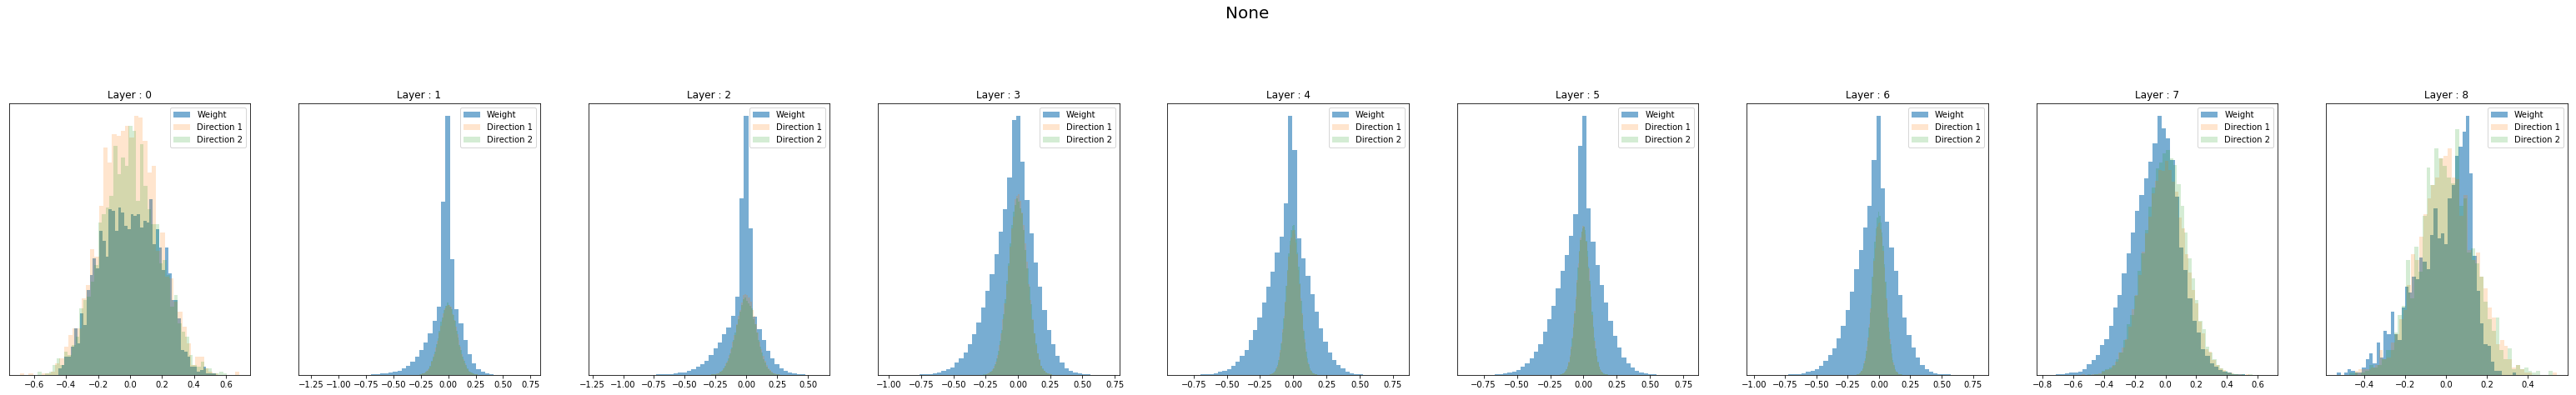

In [13]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [14]:
# Set up the direction 
current_direction1 = direction1
current_direction2 = direction2
current_loader     = trainloader

In [15]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(current_direction1, current_direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 24.147727272727273	Loss: 18.535
count: 2	Coord: [-0.5 -1. ]		Acc: 39.91477272727273	Loss: 8.174
count: 4	Coord: [ 0. -1.]		Acc: 51.70454545454545	Loss: 4.752
count: 6	Coord: [ 0.5 -1. ]		Acc: 44.46022727272727	Loss: 6.106
count: 8	Coord: [ 1. -1.]		Acc: 32.67045454545455	Loss: 11.395
count: 10	Coord: [-0.75 -0.75]		Acc: 40.625	Loss: 7.812
count: 12	Coord: [-0.25 -0.75]		Acc: 63.49431818181818	Loss: 2.813
count: 14	Coord: [ 0.25 -0.75]		Acc: 67.1875	Loss: 2.319
count: 16	Coord: [ 0.75 -0.75]		Acc: 52.69886363636363	Loss: 4.917
count: 18	Coord: [-1.  -0.5]		Acc: 33.94886363636363	Loss: 9.64
count: 20	Coord: [-0.5 -0.5]		Acc: 67.32954545454545	Loss: 2.401
count: 22	Coord: [ 0.  -0.5]		Acc: 83.23863636363636	Loss: 0.732
count: 24	Coord: [ 0.5 -0.5]		Acc: 73.57954545454545	Loss: 1.532
count: 26	Coord: [ 1.  -0.5]		Acc: 43.18181818181818	Loss: 7.521
count: 28	Coord: [-0.75 -0.25]		Acc: 57.95454545454545	Loss: 3.246
count: 30	Coord: [-0.25 -0.25]		Acc: 92.61363

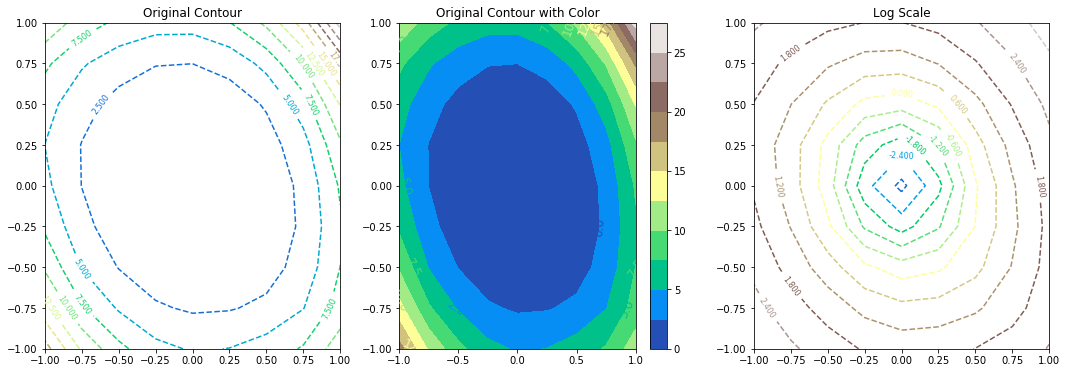

In [16]:
create_viz(loss_list,acc_list)

# ==== 2. Random - Filter Normalization - part norm (not done ) ====

# ==== 3. Random - Orth - whole norm ====

In [17]:
# exp 
np.set_printoptions(suppress=True,precision=3,)
k = np.random.randn(4,2,3,3)


temp,fdsafasd = tf.qr(k)
temptemp = tf.transpose(temp,(0,1,3,2)) @ temp
temptemp = temptemp.eval()
print(temptemp)

[[[[ 1.  0. -0.]
   [ 0.  1. -0.]
   [-0. -0.  1.]]

  [[ 1.  0. -0.]
   [ 0.  1. -0.]
   [-0. -0.  1.]]]


 [[[ 1. -0. -0.]
   [-0.  1. -0.]
   [-0. -0.  1.]]

  [[ 1. -0. -0.]
   [-0.  1. -0.]
   [-0. -0.  1.]]]


 [[[ 1.  0.  0.]
   [ 0.  1. -0.]
   [ 0. -0.  1.]]

  [[ 1.  0.  0.]
   [ 0.  1. -0.]
   [ 0. -0.  1.]]]


 [[[ 1. -0.  0.]
   [-0.  1. -0.]
   [ 0. -0.  1.]]

  [[ 1.  0. -0.]
   [ 0.  1.  0.]
   [-0.  0.  1.]]]]


In [18]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape).numpy()
        random_vector,_ = tf.qr(random_vector)
        random_vector = random_vector.eval()
        
        random_vector = torch.from_numpy(random_vector)
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))

        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))

In [19]:
direction2 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape).numpy()
        
        if random_vector.shape[0] == 10: 
            
            random_vector = np.transpose(random_vector,(2,3,1,0))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(3,2,0,1))

            random_vector = torch.from_numpy(random_vector)
            random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))

            direction2.append(random_vector)
        else:
            random_vector = np.transpose(random_vector,(2,3,0,1))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(2,3,0,1))

            random_vector = torch.from_numpy(random_vector)
            random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))

            direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

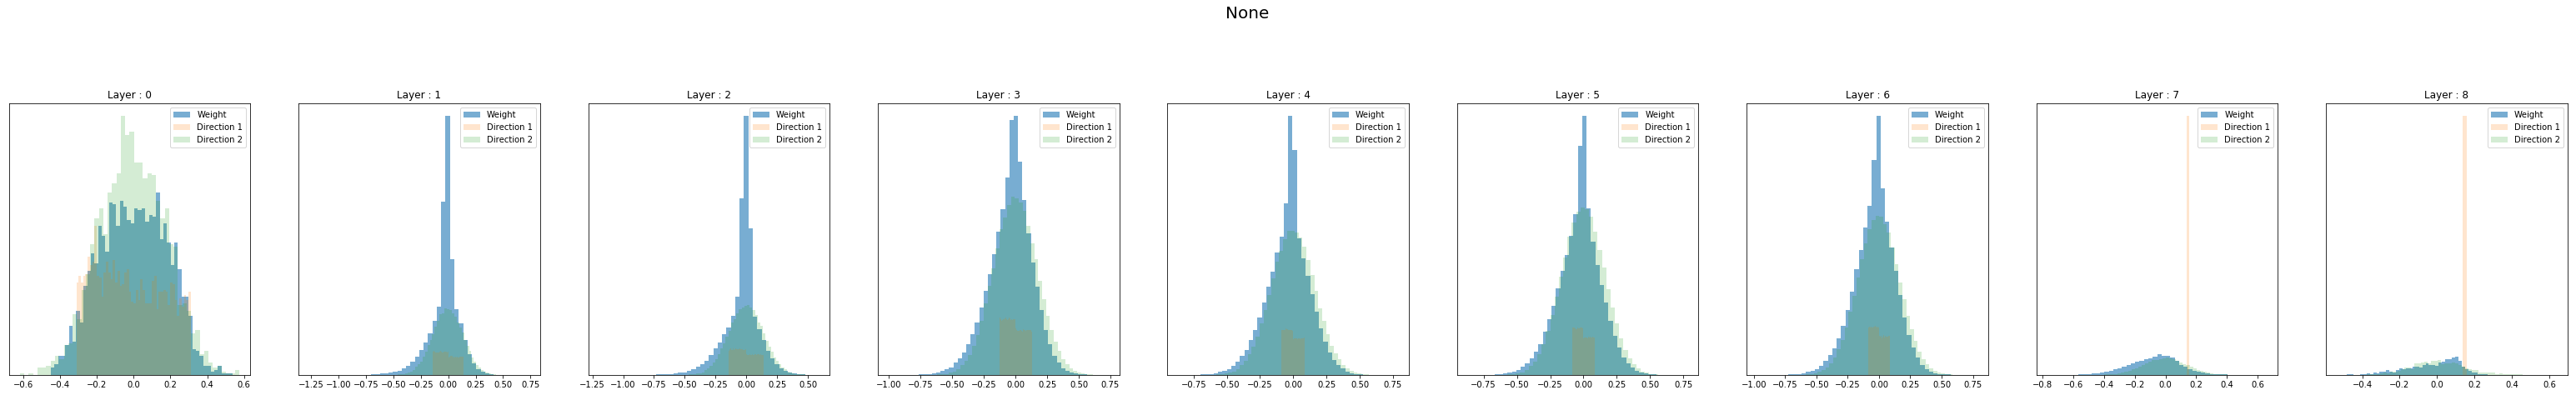

In [20]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [21]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 10.795454545454545	Loss: 2.798
count: 2	Coord: [-0.5 -1. ]		Acc: 15.767045454545455	Loss: 6.222
count: 4	Coord: [ 0. -1.]		Acc: 22.301136363636363	Loss: 33.136
count: 6	Coord: [ 0.5 -1. ]		Acc: 18.181818181818183	Loss: 169.9
count: 8	Coord: [ 1. -1.]		Acc: 10.369318181818182	Loss: 711.226
count: 10	Coord: [-0.75 -0.75]		Acc: 14.346590909090908	Loss: 2.349
count: 12	Coord: [-0.25 -0.75]		Acc: 34.09090909090909	Loss: 4.724
count: 14	Coord: [ 0.25 -0.75]		Acc: 42.75568181818182	Loss: 21.129
count: 16	Coord: [ 0.75 -0.75]		Acc: 15.767045454545455	Loss: 151.904
count: 18	Coord: [-1.  -0.5]		Acc: 15.340909090909092	Loss: 2.296
count: 20	Coord: [-0.5 -0.5]		Acc: 44.03409090909091	Loss: 1.776
count: 22	Coord: [ 0.  -0.5]		Acc: 74.7159090909091	Loss: 1.68
count: 24	Coord: [ 0.5 -0.5]		Acc: 50.56818181818182	Loss: 22.087
count: 26	Coord: [ 1.  -0.5]		Acc: 10.653409090909092	Loss: 276.833
count: 28	Coord: [-0.75 -0.25]		Acc: 33.80681818181818	Loss: 2.185
count: 30	

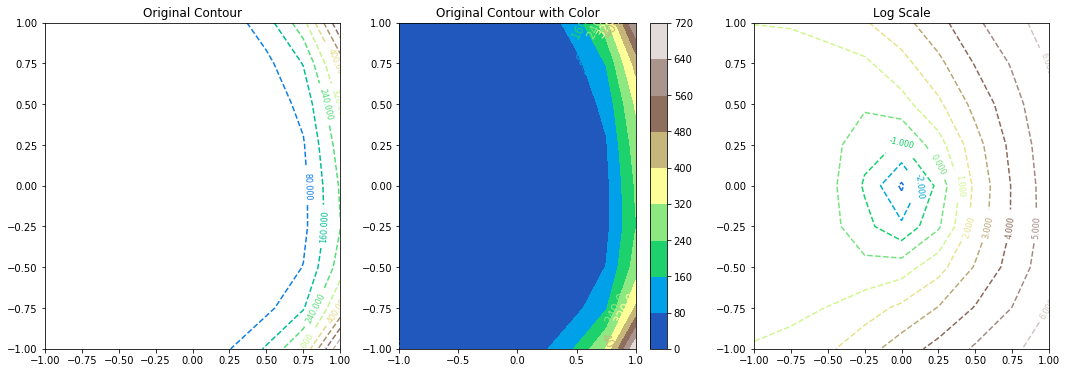

In [22]:
create_viz(loss_list,acc_list)

# ==== 4. Random - Orth - part norm ====

In [23]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape).numpy()
        random_vector,_ = tf.qr(random_vector)
        random_vector = random_vector.eval()
        
        random_vector = torch.from_numpy(random_vector).cuda()
        random_vector = random_vector * (w.norm(dim=(2,3),keepdim=True)/(random_vector.norm(dim=(2,3),keepdim=True)+1e-8))

        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))

In [24]:
direction2 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = torch.randn(w.shape).numpy()
        
        if random_vector.shape[0] == 10: 
            
            random_vector = np.transpose(random_vector,(2,3,1,0))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(3,2,0,1))

            random_vector = torch.from_numpy(random_vector).cuda()
            random_vector = random_vector * (w.norm(dim=(0,1),keepdim=True)/(random_vector.norm(dim=(0,1),keepdim=True)+1e-8))

            direction2.append(random_vector)
        else:
            random_vector = np.transpose(random_vector,(2,3,0,1))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(2,3,0,1))

            random_vector = torch.from_numpy(random_vector).cuda()
            random_vector = random_vector * (w.norm(dim=(0,1),keepdim=True)/(random_vector.norm(dim=(0,1),keepdim=True)+1e-8))

            direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

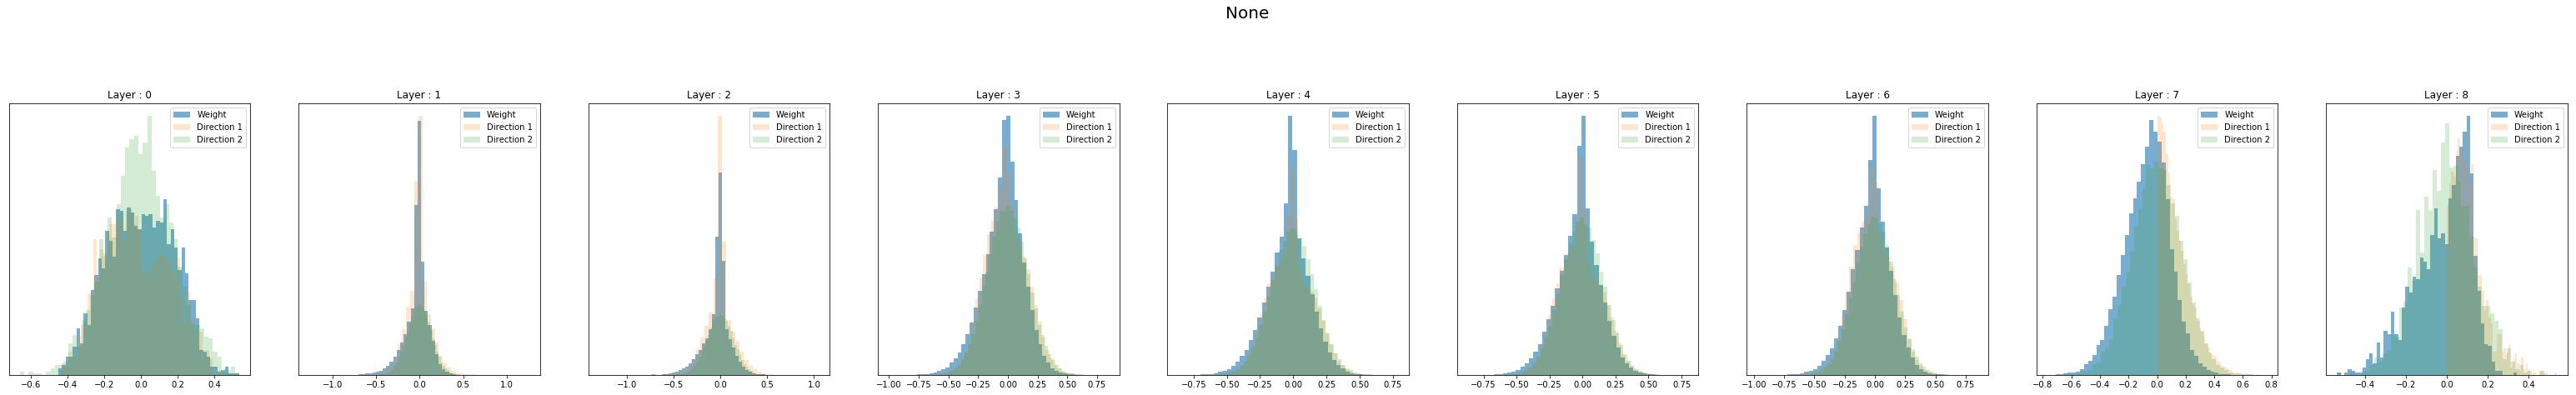

In [25]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [26]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 10.795454545454545	Loss: 257.791
count: 2	Coord: [-0.5 -1. ]		Acc: 14.772727272727273	Loss: 16.318
count: 4	Coord: [ 0. -1.]		Acc: 20.880681818181817	Loss: 20.472
count: 6	Coord: [ 0.5 -1. ]		Acc: 8.522727272727273	Loss: 167.966
count: 8	Coord: [ 1. -1.]		Acc: 7.670454545454546	Loss: 103846.461
count: 10	Coord: [-0.75 -0.75]		Acc: 11.363636363636363	Loss: 13.063
count: 12	Coord: [-0.25 -0.75]		Acc: 46.30681818181818	Loss: 4.09
count: 14	Coord: [ 0.25 -0.75]		Acc: 28.693181818181817	Loss: 16.749
count: 16	Coord: [ 0.75 -0.75]		Acc: 9.375	Loss: 4351.276
count: 18	Coord: [-1.  -0.5]		Acc: 9.232954545454545	Loss: 32.356
count: 20	Coord: [-0.5 -0.5]		Acc: 33.80681818181818	Loss: 2.622
count: 22	Coord: [ 0.  -0.5]		Acc: 78.4090909090909	Loss: 1.37
count: 24	Coord: [ 0.5 -0.5]		Acc: 13.636363636363637	Loss: 118.347
count: 26	Coord: [ 1.  -0.5]		Acc: 7.8125	Loss: 148534.908
count: 28	Coord: [-0.75 -0.25]		Acc: 11.789772727272727	Loss: 3.039
count: 30	Coord: [-0.

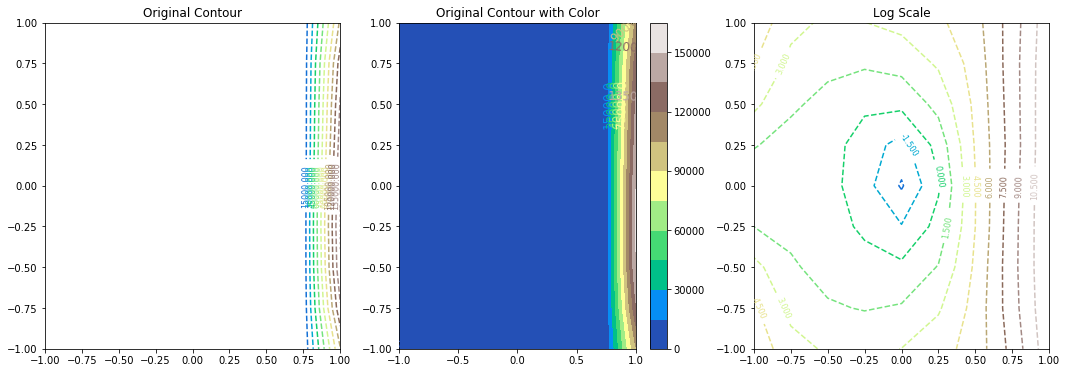

In [27]:
create_viz(loss_list,acc_list)

# ==== 5. Weight - Orth - whole norm ====

In [28]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector,_ = tf.qr(random_vector)
        random_vector = random_vector.eval()
        
        random_vector = torch.from_numpy(random_vector).cuda()
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))

        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))
        
direction2 = []
dimension  = (0,2)        
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        
        if random_vector.shape[0] == 10: 
            
            random_vector = np.transpose(random_vector,(2,3,1,0))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(3,2,0,1))

            random_vector = torch.from_numpy(random_vector).cuda()
            random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))

            direction2.append(random_vector)
        else:
            random_vector = np.transpose(random_vector,(2,3,0,1))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(2,3,0,1))

            random_vector = torch.from_numpy(random_vector).cuda()
            random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-8))

            direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

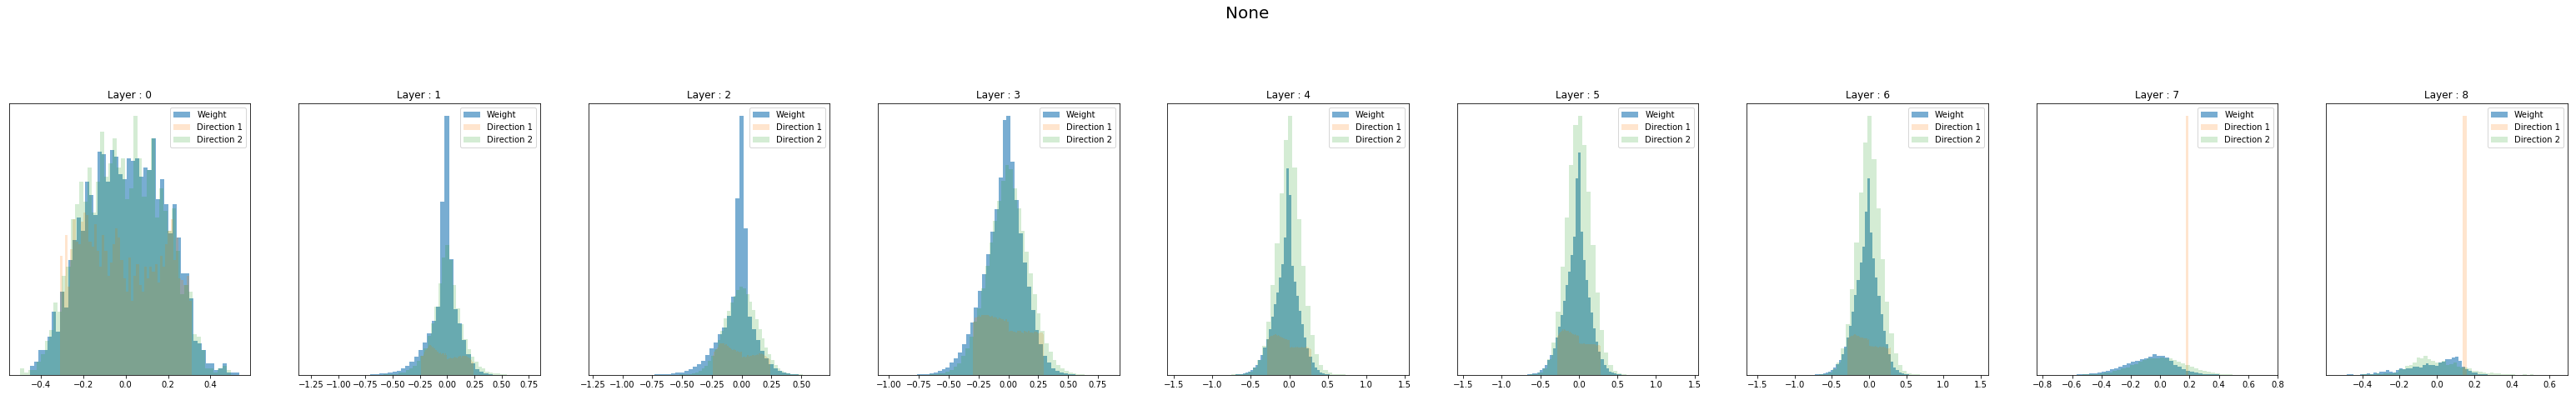

In [29]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [30]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 10.795454545454545	Loss: 617.103
count: 2	Coord: [-0.5 -1. ]		Acc: 11.647727272727273	Loss: 23.169
count: 4	Coord: [ 0. -1.]		Acc: 17.47159090909091	Loss: 56.26
count: 6	Coord: [ 0.5 -1. ]		Acc: 9.090909090909092	Loss: 401.904
count: 8	Coord: [ 1. -1.]		Acc: 9.801136363636363	Loss: 347746.962
count: 10	Coord: [-0.75 -0.75]		Acc: 9.943181818181818	Loss: 42.941
count: 12	Coord: [-0.25 -0.75]		Acc: 25.142045454545453	Loss: 10.487
count: 14	Coord: [ 0.25 -0.75]		Acc: 30.113636363636363	Loss: 21.303
count: 16	Coord: [ 0.75 -0.75]		Acc: 7.1022727272727275	Loss: 6057.232
count: 18	Coord: [-1.  -0.5]		Acc: 10.227272727272727	Loss: 49.413
count: 20	Coord: [-0.5 -0.5]		Acc: 15.198863636363637	Loss: 3.692
count: 22	Coord: [ 0.  -0.5]		Acc: 55.39772727272727	Loss: 5.181
count: 24	Coord: [ 0.5 -0.5]		Acc: 14.204545454545455	Loss: 106.917
count: 26	Coord: [ 1.  -0.5]		Acc: 8.806818181818182	Loss: 264746.261
count: 28	Coord: [-0.75 -0.25]		Acc: 9.659090909090908	Loss: 

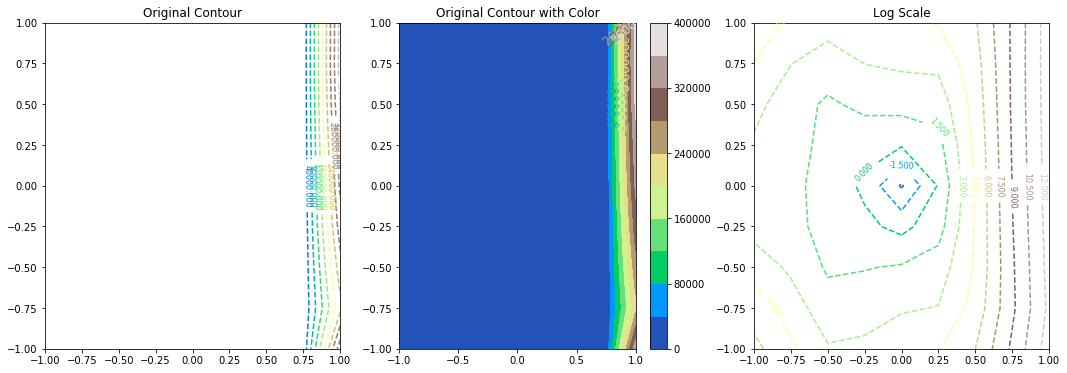

In [31]:
create_viz(loss_list,acc_list)

# ==== 6. Weight - Orth - part norm ====

In [32]:
direction1 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector,_ = tf.qr(random_vector)
        random_vector = random_vector.eval()
        
        random_vector = torch.from_numpy(random_vector).cuda()
        random_vector = random_vector * (w.norm(dim=(2,3),keepdim=True)/(random_vector.norm(dim=(2,3),keepdim=True)+1e-8))

        direction1.append(random_vector)
    else:
        direction1.append(torch.zeros_like(w))
        
direction2 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        
        if random_vector.shape[0] == 10: 
            
            random_vector = np.transpose(random_vector,(2,3,1,0))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(3,2,0,1))

            random_vector = torch.from_numpy(random_vector).cuda()
            random_vector = random_vector * (w.norm(dim=(0,1),keepdim=True)/(random_vector.norm(dim=(0,1),keepdim=True)+1e-8))

            direction2.append(random_vector)
        else:
            random_vector = np.transpose(random_vector,(2,3,0,1))
            random_vector,_ = tf.qr(random_vector)
            random_vector = random_vector.eval()
            random_vector = np.transpose(random_vector,(2,3,0,1))

            random_vector = torch.from_numpy(random_vector).cuda()
            random_vector = random_vector * (w.norm(dim=(0,1),keepdim=True)/(random_vector.norm(dim=(0,1),keepdim=True)+1e-8))

            direction2.append(random_vector)
    else:
        direction2.append(torch.zeros_like(w))

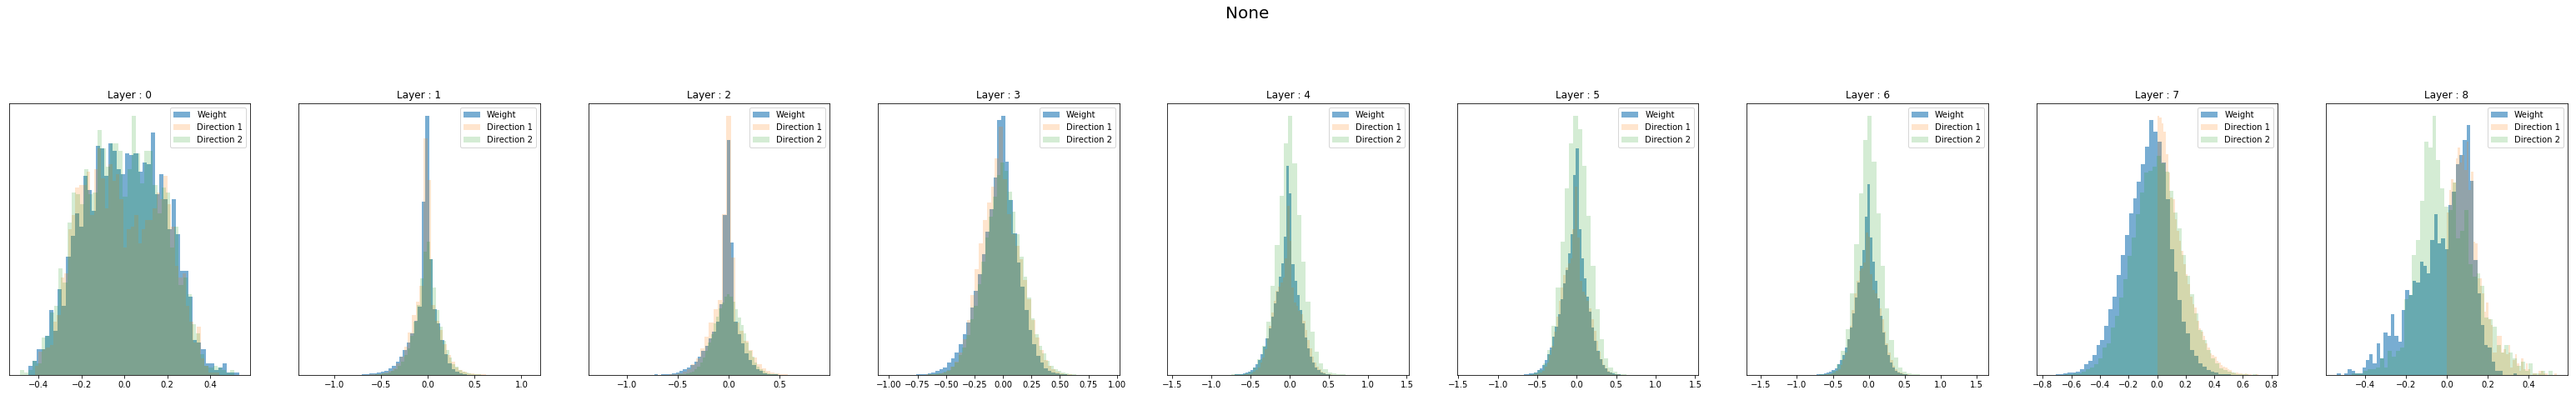

In [33]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [34]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 7.954545454545454	Loss: 448.532
count: 2	Coord: [-0.5 -1. ]		Acc: 12.357954545454545	Loss: 34.511
count: 4	Coord: [ 0. -1.]		Acc: 17.613636363636363	Loss: 55.787
count: 6	Coord: [ 0.5 -1. ]		Acc: 11.931818181818182	Loss: 166.152
count: 8	Coord: [ 1. -1.]		Acc: 11.789772727272727	Loss: 90759.327
count: 10	Coord: [-0.75 -0.75]		Acc: 11.221590909090908	Loss: 26.154
count: 12	Coord: [-0.25 -0.75]		Acc: 26.420454545454547	Loss: 14.606
count: 14	Coord: [ 0.25 -0.75]		Acc: 31.676136363636363	Loss: 14.261
count: 16	Coord: [ 0.75 -0.75]		Acc: 9.090909090909092	Loss: 2556.978
count: 18	Coord: [-1.  -0.5]		Acc: 10.9375	Loss: 42.936
count: 20	Coord: [-0.5 -0.5]		Acc: 17.1875	Loss: 4.515
count: 22	Coord: [ 0.  -0.5]		Acc: 54.6875	Loss: 5.22
count: 24	Coord: [ 0.5 -0.5]		Acc: 14.346590909090908	Loss: 51.569
count: 26	Coord: [ 1.  -0.5]		Acc: 8.522727272727273	Loss: 57415.11
count: 28	Coord: [-0.75 -0.25]		Acc: 12.073863636363637	Loss: 3.492
count: 30	Coord: [-0.25 -0.

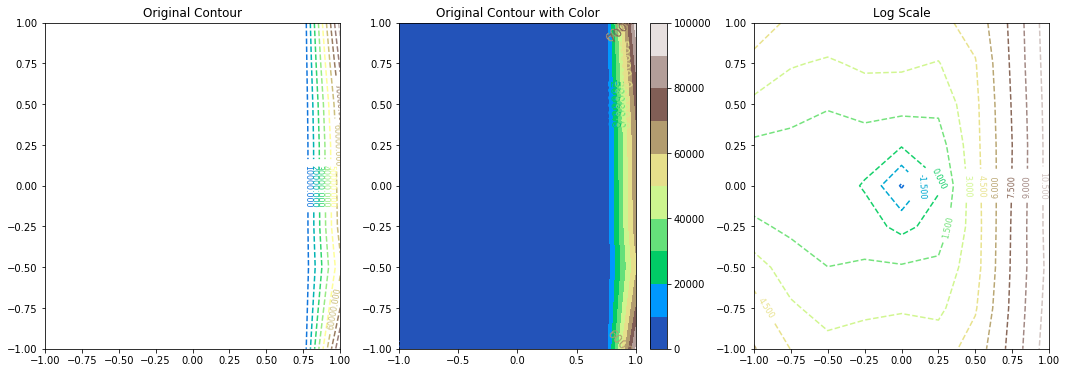

In [35]:
create_viz(loss_list,acc_list)

# ==== 7. Weigth - PCA - Two Direction the whole weight  ====

In [36]:
direction1 = []
direction2 = []
dimension  = (0,2)
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = random_vector.reshape((random_vector.shape[0]*random_vector.shape[1],random_vector.shape[2]*random_vector.shape[3]))
        
        s,u,v  = tf.svd(random_vector,False)
        recon1 = u @ tf.diag(s)[:,:1]  @ tf.transpose(v)[:1 ,:]
        recon2 = u @ tf.diag(s)[:,1:2] @ tf.transpose(v)[1:2,:]
        
        recon1 = recon1.eval().reshape((w.shape[0],w.shape[1],w.shape[2],w.shape[3]))
        recon2 = recon2.eval().reshape((w.shape[0],w.shape[1],w.shape[2],w.shape[3]))
        recon1 = torch.from_numpy(recon1)
        recon2 = torch.from_numpy(recon2)
        
        recon1 = recon1 * (w.norm()/(recon1.norm()+1e-8))
        recon2 = recon2 * (w.norm()/(recon2.norm()+1e-8))
        print(recon1.shape,recon2.shape)
        direction1.append(recon1)
        direction2.append(recon2)
    else:
        direction1.append(torch.zeros_like(w))
        direction2.append(torch.zeros_like(w))

torch.Size([96, 3, 3, 3]) torch.Size([96, 3, 3, 3])
torch.Size([96, 96, 3, 3]) torch.Size([96, 96, 3, 3])
torch.Size([96, 96, 3, 3]) torch.Size([96, 96, 3, 3])
torch.Size([192, 96, 3, 3]) torch.Size([192, 96, 3, 3])
torch.Size([192, 192, 3, 3]) torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3]) torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 3, 3]) torch.Size([192, 192, 3, 3])
torch.Size([192, 192, 1, 1]) torch.Size([192, 192, 1, 1])
torch.Size([10, 192, 1, 1]) torch.Size([10, 192, 1, 1])


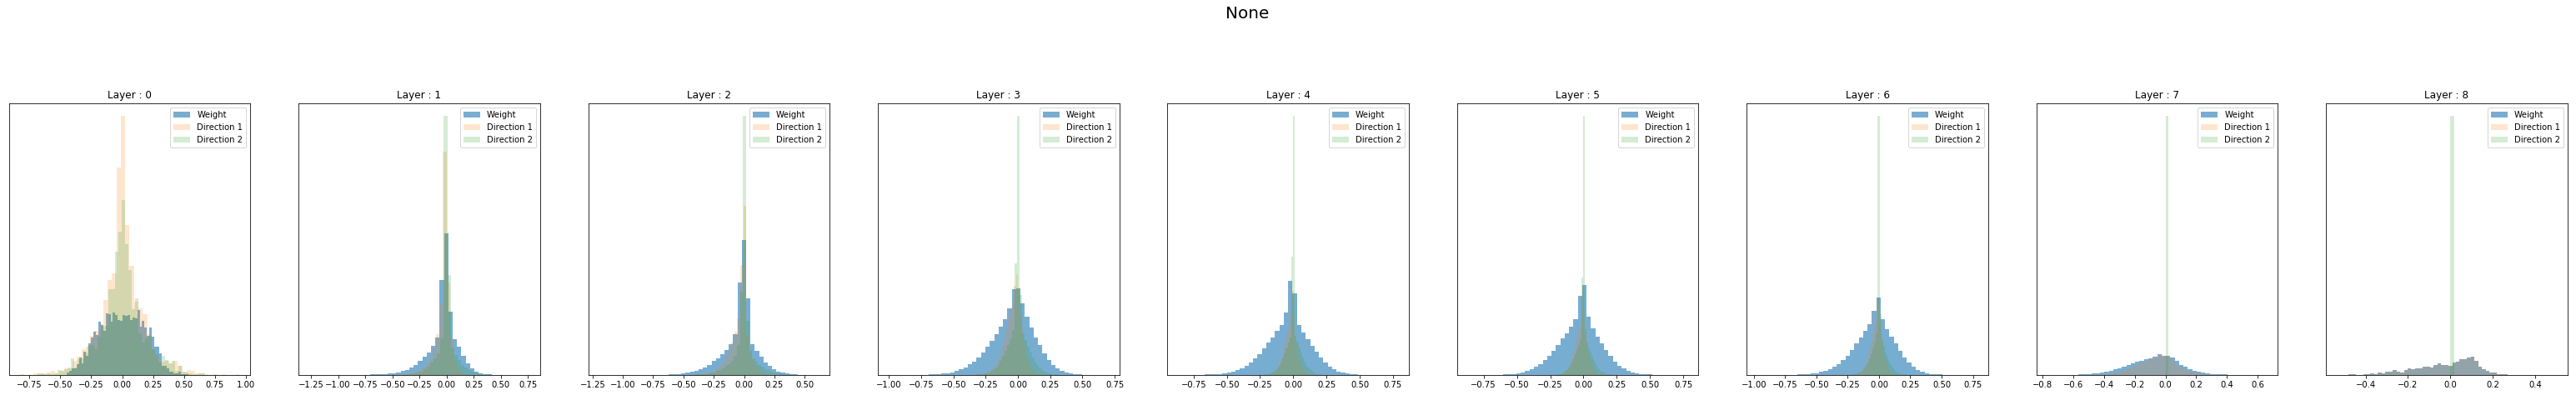

In [37]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [38]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 10.369318181818182	Loss: 2.303
count: 2	Coord: [-0.5 -1. ]		Acc: 13.352272727272727	Loss: 2.555
count: 4	Coord: [ 0. -1.]		Acc: 16.335227272727273	Loss: 4.113
count: 6	Coord: [ 0.5 -1. ]		Acc: 13.068181818181818	Loss: 40.319
count: 8	Coord: [ 1. -1.]		Acc: 12.642045454545455	Loss: 429.499
count: 10	Coord: [-0.75 -0.75]		Acc: 10.085227272727273	Loss: 2.377
count: 12	Coord: [-0.25 -0.75]		Acc: 19.602272727272727	Loss: 2.533
count: 14	Coord: [ 0.25 -0.75]		Acc: 16.477272727272727	Loss: 6.501
count: 16	Coord: [ 0.75 -0.75]		Acc: 14.630681818181818	Loss: 92.25
count: 18	Coord: [-1.  -0.5]		Acc: 8.238636363636363	Loss: 2.303
count: 20	Coord: [-0.5 -0.5]		Acc: 26.136363636363637	Loss: 2.109
count: 22	Coord: [ 0.  -0.5]		Acc: 28.693181818181817	Loss: 3.056
count: 24	Coord: [ 0.5 -0.5]		Acc: 16.90340909090909	Loss: 20.096
count: 26	Coord: [ 1.  -0.5]		Acc: 13.068181818181818	Loss: 264.038
count: 28	Coord: [-0.75 -0.25]		Acc: 23.295454545454547	Loss: 2.167
count: 

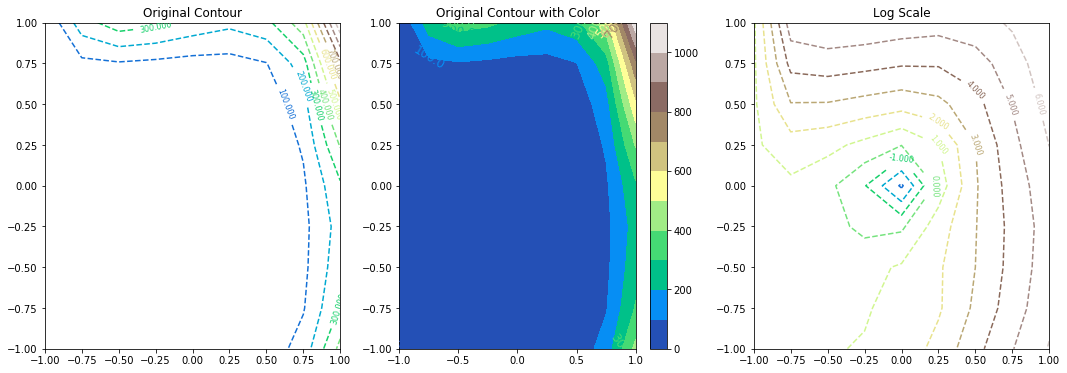

In [39]:
create_viz(loss_list,acc_list)

# ==== 8. Weight - PCA - One mix of 0,2 and another mix of 1,3 ====

In [40]:
direction1 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(1,3,0,2))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:,:1]  @ tf.transpose(v,(0,1,3,2))[:,:,:1 ,:]
        
        recon = recon.eval()
        recon = np.transpose(recon,(2,0,3,1))
        recon = torch.from_numpy(recon)
        
        recon = recon * (w.norm()/(recon.norm()+1e-8))
        direction1.append(recon)
    else:
        direction1.append(torch.zeros_like(w))

direction2 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(0,2,1,3))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:,:1]  @ tf.transpose(v,(0,1,3,2))[:,:,:1 ,:]
        
        recon = recon.eval()
        recon = np.transpose(recon,(0,2,1,3))
        recon = torch.from_numpy(recon)
        
        recon = recon * (w.norm()/(recon.norm()+1e-8))
        direction2.append(recon)
    else:
        direction2.append(torch.zeros_like(w))

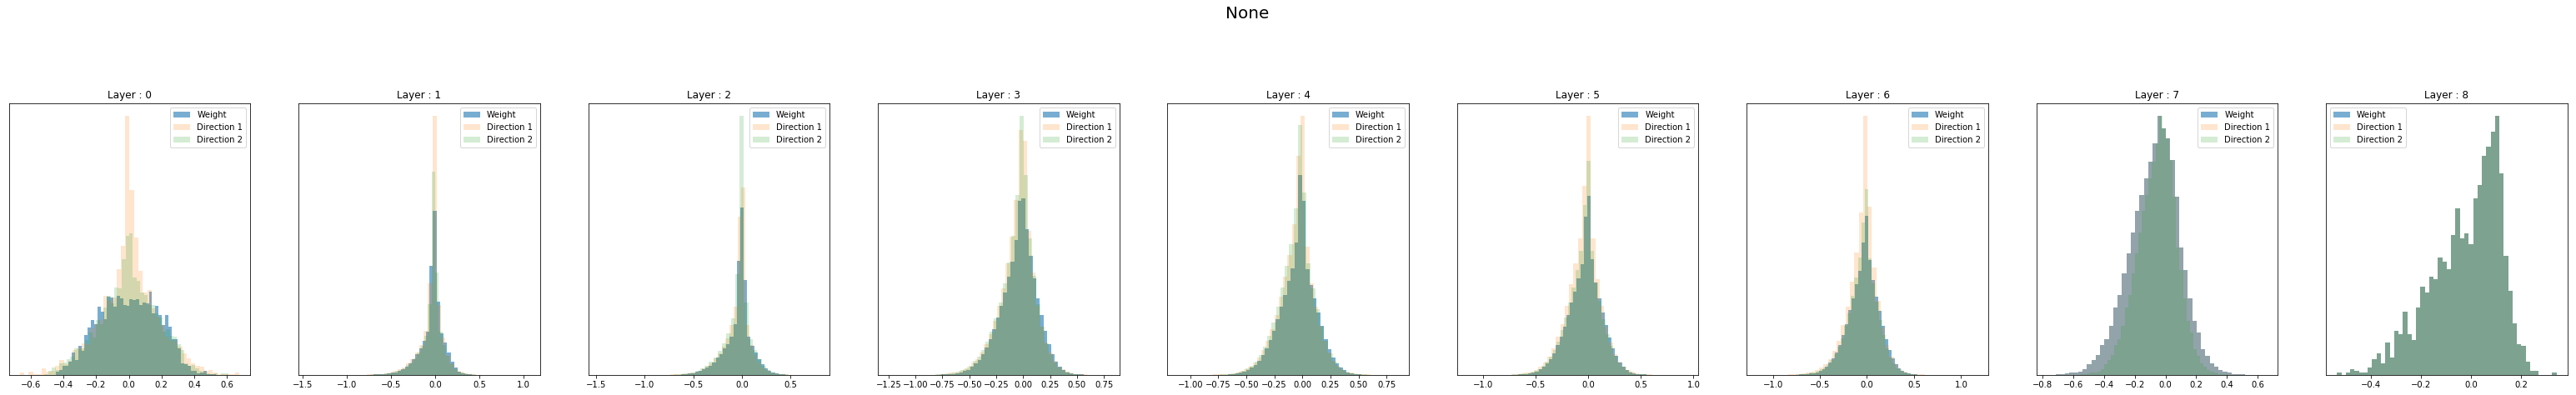

In [41]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [42]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 9.801136363636363	Loss: 696224722571.636
count: 2	Coord: [-0.5 -1. ]		Acc: 9.801136363636363	Loss: 3259187409.455
count: 4	Coord: [ 0. -1.]		Acc: 10.369318181818182	Loss: 2.303
count: 6	Coord: [ 0.5 -1. ]		Acc: 8.806818181818182	Loss: 25.347
count: 8	Coord: [ 1. -1.]		Acc: 8.238636363636363	Loss: 1159.751
count: 10	Coord: [-0.75 -0.75]		Acc: 9.801136363636363	Loss: 4369553012.364
count: 12	Coord: [-0.25 -0.75]		Acc: 10.369318181818182	Loss: 2.303
count: 14	Coord: [ 0.25 -0.75]		Acc: 7.954545454545454	Loss: 6.377
count: 16	Coord: [ 0.75 -0.75]		Acc: 9.517045454545455	Loss: 407.808
count: 18	Coord: [-1.  -0.5]		Acc: 9.801136363636363	Loss: 6083605504.0
count: 20	Coord: [-0.5 -0.5]		Acc: 10.369318181818182	Loss: 2.303
count: 22	Coord: [ 0.  -0.5]		Acc: 12.357954545454545	Loss: 2.388
count: 24	Coord: [ 0.5 -0.5]		Acc: 11.647727272727273	Loss: 101.452
count: 26	Coord: [ 1.  -0.5]		Acc: 10.9375	Loss: 2226.645
count: 28	Coord: [-0.75 -0.25]		Acc: 10.36931818181

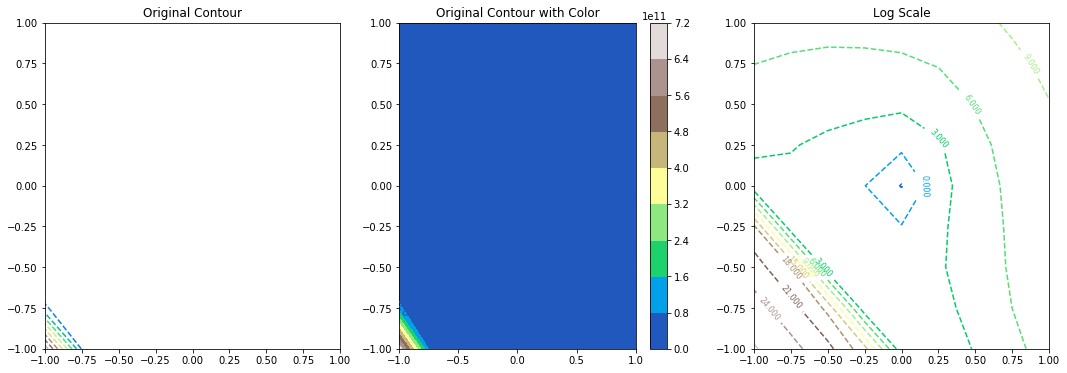

In [43]:
create_viz(loss_list,acc_list)

# ==== 9. Weight - PCA - adjusted ====

In [44]:
direction1 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(1,3,0,2))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:,:1]  @ tf.transpose(v,(0,1,3,2))[:,:,:1 ,:]
        
        recon = recon.eval()
        recon = np.transpose(recon,(2,0,3,1))
        recon = torch.from_numpy(recon)
        
        recon = recon * (w.norm()/(recon.norm()**1.5+1e-8))
        direction1.append(recon)
    else:
        direction1.append(torch.zeros_like(w))

direction2 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(0,2,1,3))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:,:1]  @ tf.transpose(v,(0,1,3,2))[:,:,:1 ,:]
        
        recon = recon.eval()
        recon = np.transpose(recon,(0,2,1,3))
        recon = torch.from_numpy(recon)
        
        recon = recon * (w.norm()/(recon.norm()**1.5+1e-8))
        direction2.append(recon)
    else:
        direction2.append(torch.zeros_like(w))

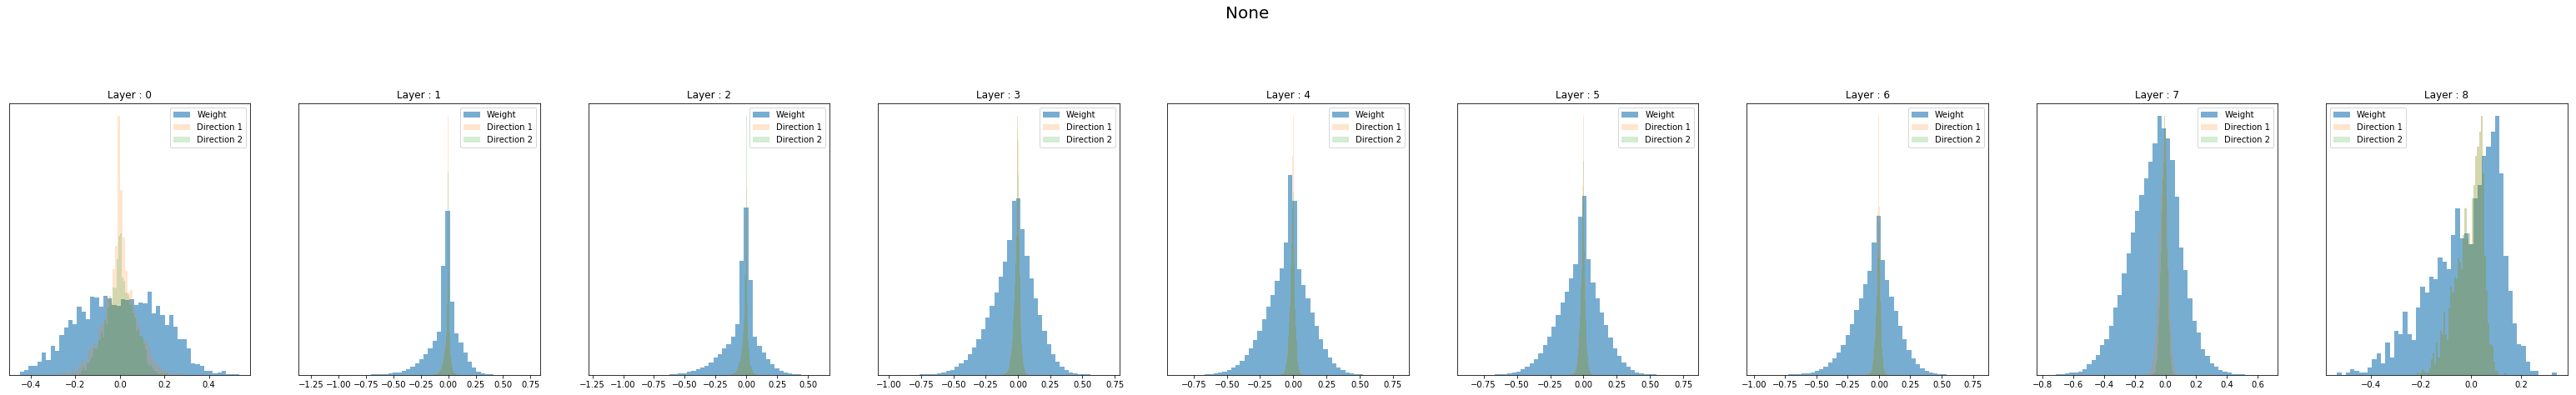

In [45]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [46]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 49.14772727272727	Loss: 2.208
count: 2	Coord: [-0.5 -1. ]		Acc: 82.24431818181819	Loss: 1.494
count: 4	Coord: [ 0. -1.]		Acc: 91.05113636363636	Loss: 0.533
count: 6	Coord: [ 0.5 -1. ]		Acc: 79.6875	Loss: 0.638
count: 8	Coord: [ 1. -1.]		Acc: 62.5	Loss: 3.03
count: 10	Coord: [-0.75 -0.75]		Acc: 75.85227272727273	Loss: 1.541
count: 12	Coord: [-0.25 -0.75]		Acc: 94.0340909090909	Loss: 0.453
count: 14	Coord: [ 0.25 -0.75]		Acc: 92.4715909090909	Loss: 0.234
count: 16	Coord: [ 0.75 -0.75]		Acc: 79.4034090909091	Loss: 1.224
count: 18	Coord: [-1.  -0.5]		Acc: 66.05113636363636	Loss: 1.608
count: 20	Coord: [-0.5 -0.5]		Acc: 92.32954545454545	Loss: 0.496
count: 22	Coord: [ 0.  -0.5]		Acc: 97.44318181818181	Loss: 0.096
count: 24	Coord: [ 0.5 -0.5]		Acc: 91.9034090909091	Loss: 0.389
count: 26	Coord: [ 1.  -0.5]		Acc: 76.98863636363636	Loss: 2.883
count: 28	Coord: [-0.75 -0.25]		Acc: 84.23295454545455	Loss: 0.644
count: 30	Coord: [-0.25 -0.25]		Acc: 98.1534090909091	

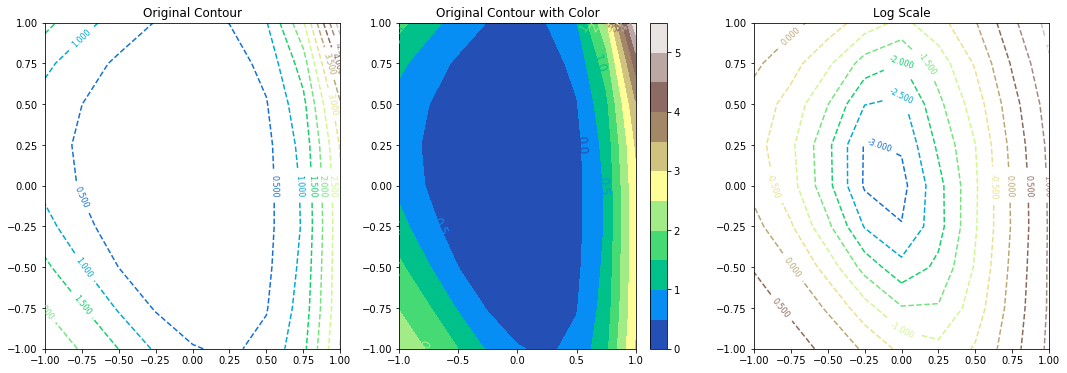

In [47]:
create_viz(loss_list,acc_list)

# ==== 10. PCA - Weight - PCA last Principle Compoenent ====

In [48]:
direction1 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(1,3,0,2))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:,-1:]  @ tf.transpose(v,(0,1,3,2))[:,:,-1: ,:]
        
        recon = recon.eval()
        recon = np.transpose(recon,(2,0,3,1))
        recon = torch.from_numpy(recon)
        
        recon = recon * (w.norm()/(recon.norm()**1.5+1e-8))
        direction1.append(recon)
    else:
        direction1.append(torch.zeros_like(w))

direction2 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(0,2,1,3))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:,-1:]  @ tf.transpose(v,(0,1,3,2))[:,:,-1: ,:]
        
        recon = recon.eval()
        recon = np.transpose(recon,(0,2,1,3))
        recon = torch.from_numpy(recon)
        
        recon = recon * (w.norm()/(recon.norm()**1.5+1e-8))
        direction2.append(recon)
    else:
        direction2.append(torch.zeros_like(w))

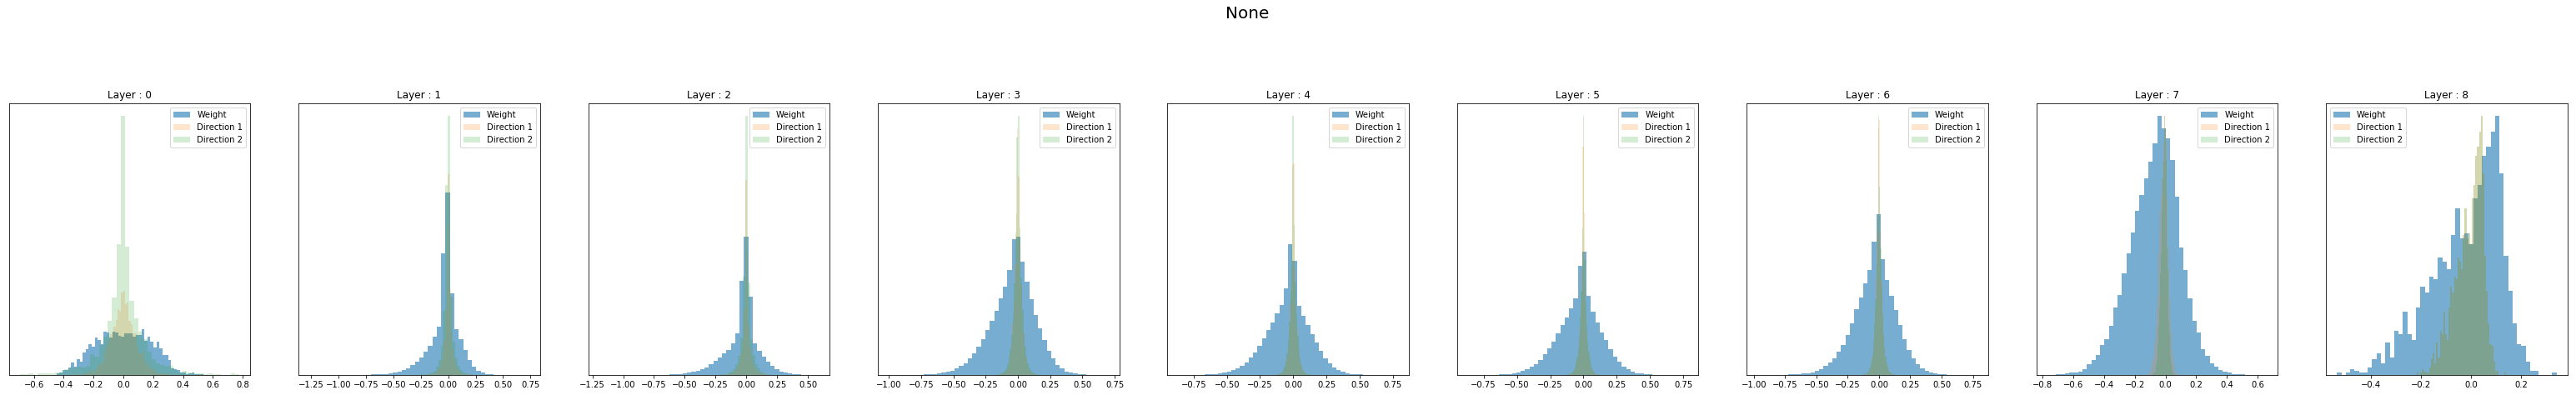

In [49]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [50]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 60.79545454545455	Loss: 1.573
count: 2	Coord: [-0.5 -1. ]		Acc: 69.0340909090909	Loss: 0.974
count: 4	Coord: [ 0. -1.]		Acc: 75.2840909090909	Loss: 0.782
count: 6	Coord: [ 0.5 -1. ]		Acc: 70.0284090909091	Loss: 1.483
count: 8	Coord: [ 1. -1.]		Acc: 58.52272727272727	Loss: 4.795
count: 10	Coord: [-0.75 -0.75]		Acc: 76.8465909090909	Loss: 0.809
count: 12	Coord: [-0.25 -0.75]		Acc: 86.2215909090909	Loss: 0.412
count: 14	Coord: [ 0.25 -0.75]		Acc: 85.6534090909091	Loss: 0.537
count: 16	Coord: [ 0.75 -0.75]		Acc: 72.30113636363636	Loss: 2.195
count: 18	Coord: [-1.  -0.5]		Acc: 79.9715909090909	Loss: 0.751
count: 20	Coord: [-0.5 -0.5]		Acc: 91.05113636363636	Loss: 0.289
count: 22	Coord: [ 0.  -0.5]		Acc: 94.31818181818181	Loss: 0.145
count: 24	Coord: [ 0.5 -0.5]		Acc: 85.9375	Loss: 0.684
count: 26	Coord: [ 1.  -0.5]		Acc: 65.05681818181819	Loss: 4.518
count: 28	Coord: [-0.75 -0.25]		Acc: 90.19886363636364	Loss: 0.32
count: 30	Coord: [-0.25 -0.25]		Acc: 97.5852

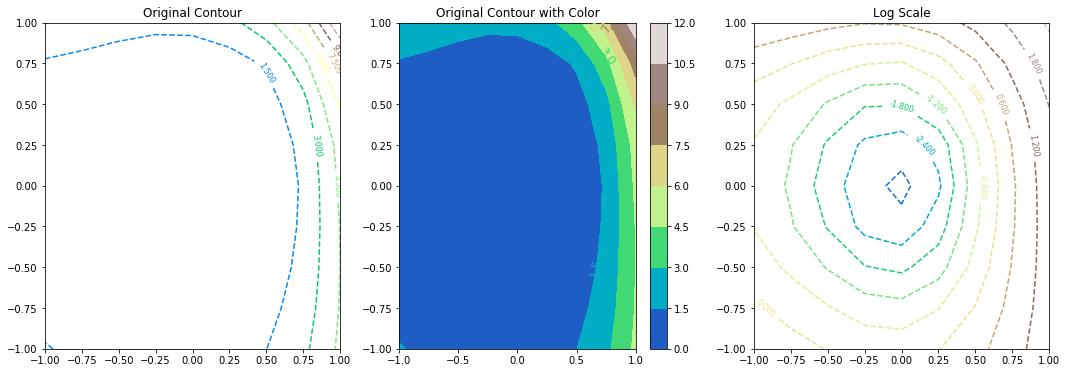

In [51]:
create_viz(loss_list,acc_list)

# ==== 11. PCA - Weight - For each Filters ====

In [52]:
direction1 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        
        random_vector = w.clone().cpu().numpy()
        random_vector = random_vector.reshape((random_vector.shape[0],random_vector.shape[1],random_vector.shape[2]*random_vector.shape[3]))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:1] @ tf.transpose(v,(0,2,1))[:,:1,:]
        recon  = recon.eval()

        recon  = recon.reshape((w.shape[0],w.shape[1],w.shape[2],w.shape[3]))
        recon  = torch.from_numpy(recon)
        recon  = recon * (w.norm()/(recon.norm()**1.5+1e-8))
        
        direction1.append(recon)
    else:
        direction1.append(torch.zeros_like(w))
        
direction2 = []
for w in copy_of_the_weights:
    if w.dim() == 4:
        
        random_vector = w.clone().cpu().numpy()
        random_vector = np.transpose(random_vector,(1,0,2,3))
        random_vector = random_vector.reshape((w.shape[1],w.shape[0],w.shape[2]*w.shape[3]))

        s,u,v  = tf.svd(random_vector,False)
        recon  = u @ tf.linalg.diag(s)[:,:,:1] @ tf.transpose(v,(0,2,1))[:,:1,:]
        recon  = recon.eval()
        
        recon  = recon.reshape((w.shape[1],w.shape[0],w.shape[2],w.shape[3]))
        recon  = np.transpose(recon,(1,0,2,3))
        recon  = torch.from_numpy(recon)
        recon  = recon * (w.norm()/(recon.norm()**1.5+1e-8))
        
        direction2.append(recon)
    else:
        direction2.append(torch.zeros_like(w))

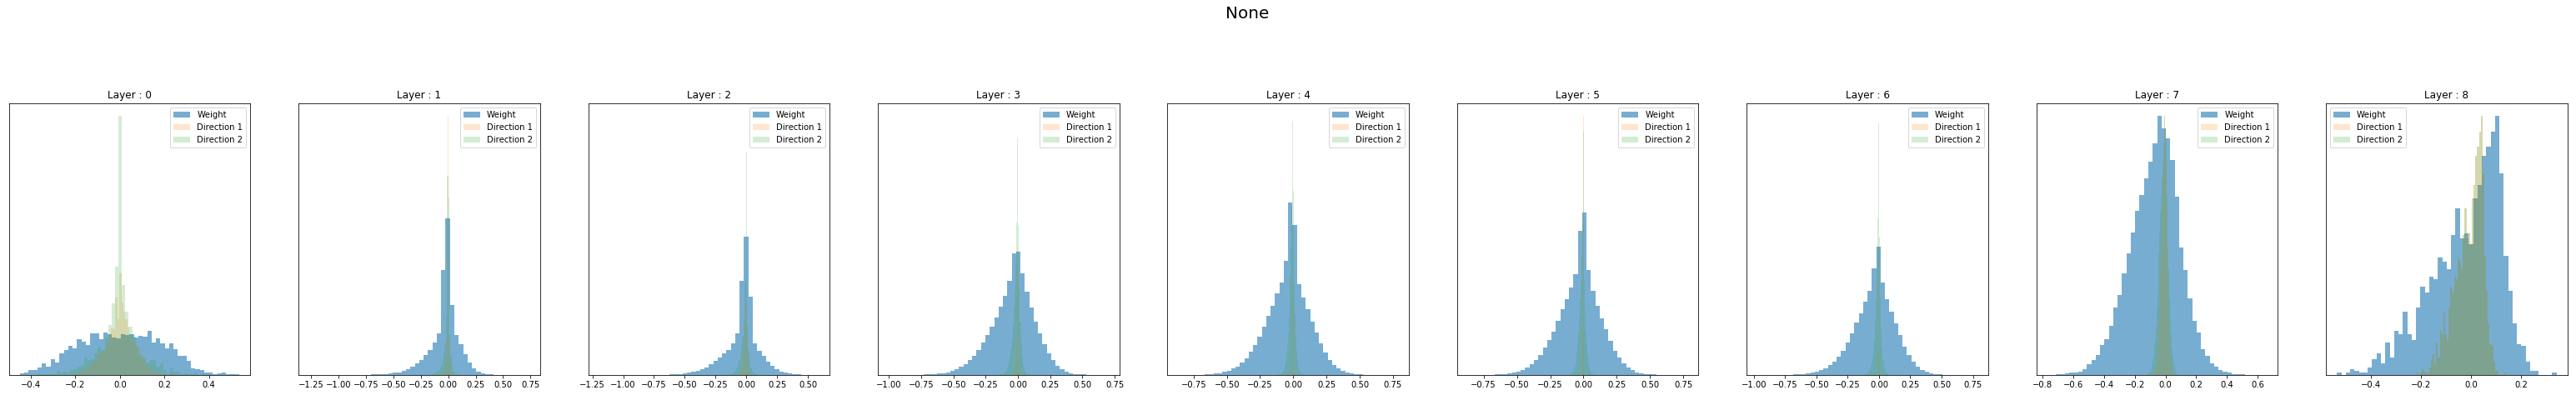

In [53]:
viz_histogram_weights(copy_of_the_weights,direction1,direction2)

In [54]:
# start the evaluation
loss_list = np.zeros((numebr_of_points,numebr_of_points)); acc_list  = np.zeros((numebr_of_points,numebr_of_points))
col_value = 0

for count, ind in enumerate(inds):
    
    # change the weight values
    coord   = coordinate[count]
    changes = [d0.cuda()*coord[0] + d1.cuda()*coord[1] for (d0, d1) in zip(direction1, direction2)]
    for (p, w, d) in zip(net.parameters(), weight, changes): p.data = w + d

    # start the evaluation
    correct = 0; total_loss = 0; total = 0 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(current_loader):
            batch_size = inputs.size(0)
            total      = total + batch_size
            
            inputs, targets = Variable(inputs).cuda(),Variable(targets).cuda()
            
            outputs = net(inputs)
            loss    = criterion(outputs, targets)
            total_loss   = total_loss + loss.item()*batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct      = correct + predicted.eq(targets).sum().item()
            sys.stdout.write("Coord: "+str(coord)+"\tAcc: "+str(predicted.eq(targets).sum().item())+"\tLoss: "+str(np.around(loss.item(),3))+"\r")
            sys.stdout.flush()
            
            if batch_idx==10: break
            
        if count % 2 == 0 : sys.stdout.write("count: "+str(count)+"\tCoord: "+str(coord)+"\t\tAcc: "+str(100.*correct/total)+"\tLoss: "+str(np.around(total_loss/total,3))+"\n")
        
    # store value 
    loss_list[col_value][ind%numebr_of_points] = total_loss/total
    acc_list [col_value][ind%numebr_of_points] = 100.*correct/total
    ind_compare = ind + 1
    if ind_compare % numebr_of_points == 0 :  col_value = col_value + 1

count: 0	Coord: [-1. -1.]		Acc: 46.875	Loss: 1.976
count: 2	Coord: [-0.5 -1. ]		Acc: 60.79545454545455	Loss: 1.275
count: 4	Coord: [ 0. -1.]		Acc: 70.45454545454545	Loss: 0.92
count: 6	Coord: [ 0.5 -1. ]		Acc: 76.13636363636364	Loss: 0.928
count: 8	Coord: [ 1. -1.]		Acc: 80.11363636363636	Loss: 1.201
count: 10	Coord: [-0.75 -0.75]		Acc: 71.5909090909091	Loss: 1.113
count: 12	Coord: [-0.25 -0.75]		Acc: 80.25568181818181	Loss: 0.577
count: 14	Coord: [ 0.25 -0.75]		Acc: 86.2215909090909	Loss: 0.421
count: 16	Coord: [ 0.75 -0.75]		Acc: 89.63068181818181	Loss: 0.474
count: 18	Coord: [-1.  -0.5]		Acc: 81.10795454545455	Loss: 0.975
count: 20	Coord: [-0.5 -0.5]		Acc: 91.9034090909091	Loss: 0.345
count: 22	Coord: [ 0.  -0.5]		Acc: 94.74431818181819	Loss: 0.164
count: 24	Coord: [ 0.5 -0.5]		Acc: 96.30681818181819	Loss: 0.135
count: 26	Coord: [ 1.  -0.5]		Acc: 95.3125	Loss: 0.2
count: 28	Coord: [-0.75 -0.25]		Acc: 95.17045454545455	Loss: 0.227
count: 30	Coord: [-0.25 -0.25]		Acc: 97.7272727272727

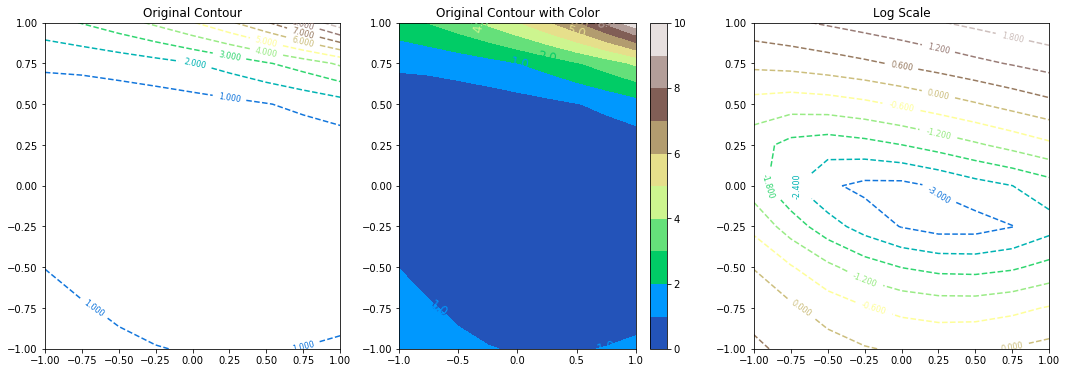

In [55]:
create_viz(loss_list,acc_list)